In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import feather
import warnings
import time
import sys
import datetime
import re
import gc
import os

from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

from scipy.stats import mode
from scipy import stats
from sklearn import preprocessing


from IPython.core.display import display, HTML

In [2]:
historical_transactions = pd.read_csv('C:\\kdata\\historical_transactions.csv', parse_dates=['purchase_date'])

In [13]:
df_train = pd.read_csv('data\\train.csv')

In [3]:
def featurize_train_test(df):
    # to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']


    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

    t1 = pd.get_dummies(df_train.feature_1, prefix = 'feature1')
    t2 = pd.get_dummies(df_train.feature_2, prefix = 'feature2')
    t3 = pd.get_dummies(df_train.feature_3, prefix = 'feature3')

    df[t1.columns] = t1
    df[t2.columns] = t2
    df[t3.columns] = t3

    del t1, t2, t3
    gc.collect()

    return df

In [14]:
train_fe = featurize_train_test(train)

In [15]:
train_fe

,first_active_month,card_id,feature_1,feature_2,feature_3,target,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var,feature1_1,feature1_2,feature1_3,feature1_4,feature1_5,feature2_1,feature2_2,feature2_3,feature3_0,feature3_1
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,2,643,3215,1286,643,0.007776,0.003110,0.001555,8,2.666667,5,1,2.081666,0,0,0,0,1,0,1,0,0,1
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,794,3176,794,0,0.005038,0.001259,0.000000,5,1.666667,4,0,2.081666,0,0,0,1,0,1,0,0,1,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,3,947,1894,1894,0,0.002112,0.002112,0.000000,4,1.333333,2,0,1.154701,0,1,0,0,0,0,1,0,1,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,3,551,2204,1653,0,0.007260,0.005445,0.000000,7,2.333333,4,0,2.081666,0,0,0,1,0,0,0,1,1,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,4,490,490,1470,0,0.002041,0.006122,0.000000,4,1.333333,3,0,1.527525,1,0,0,0,0,0,0,1,1,0
5,2016-09-01,C_ID_0894217f2f,4,2,0,0.871585,3,916,3664,1832,0,0.004367,0.002183,0.000000,6,2.000000,4,0,2.000000,0,0,0,1,0,0,1,0,1,0
6,2016-12-01,C_ID_7e63323c00,3,2,1,0.230129,4,825,2475,1650,825,0.003636,0.002424,0.001212,6,2.000000,3,1,1.000000,0,0,1,0,0,0,1,0,0,1
7,2017-09-01,C_ID_dfa21fc124,3,2,1,2.135850,3,551,1653,1102,551,0.005445,0.003630,0.001815,6,2.000000,3,1,1.000000,0,0,1,0,0,0,1,0,0,1
8,2017-08-01,C_ID_fe0fdac8ea,2,1,0,-0.065406,3,582,1164,582,0,0.003436,0.001718,0.000000,3,1.000000,2,0,1.000000,0,1,0,0,0,1,0,0,1,0
9,2016-08-01,C_ID_bf62c0b49d,2,2,0,0.300062,3,947,1894,1894,0,0.002112,0.002112,0.000000,4,1.333333,2,0,1.154701,0,1,0,0,0,0,1,0,1,0


In [17]:
df_category3_count = historical_transactions.groupby('card_id')['category_3'].value_counts()

In [20]:
df_category3_count = df_category3_count.unstack()

In [21]:
df_category3_fraction = np.divide(df_category3_count, df_category3_count.sum(axis = 1).values.reshape(-1,1))

In [23]:
city_id_count = historical_transactions.groupby('city_id')['city_id'].count()

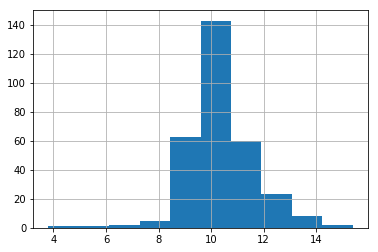

In [26]:
np.log(city_id_count).hist()

In [38]:
bins = pd.qcut(np.log(city_id_count), 5, duplicates='drop')

In [54]:
pd.qcut(np.log(city_id_count), 5, duplicates='drop',labels=range(5))

city_id
-1      4
 1      4
 2      1
 3      3
 4      4
 6      2
 7      2
 8      4
 9      2
 10     2
 11     4
 12     4
 13     2
 14     3
 16     0
 17     4
 18     0
 19     4
 20     4
 21     4
 22     2
 23     2
 24     4
 25     4
 26     0
 28     2
 29     2
 30     4
 32     0
 33     3
       ..
 314    4
 315    0
 316    0
 318    2
 319    0
 320    3
 321    0
 322    4
 323    3
 325    2
 326    0
 327    0
 328    2
 329    2
 330    2
 331    4
 333    4
 334    3
 335    0
 336    0
 337    1
 338    1
 339    3
 340    4
 341    2
 342    1
 343    0
 344    4
 345    0
 347    3
Name: city_id, Length: 308, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

In [40]:
df1 = historical_transactions['city_id'].map(bins)

In [51]:
df1

0           (11.183, 15.391]
1           (11.183, 15.391]
2           (11.183, 15.391]
3           (11.183, 15.391]
4           (11.183, 15.391]
5           (11.183, 15.391]
6           (11.183, 15.391]
7           (10.474, 11.183]
8           (11.183, 15.391]
9           (11.183, 15.391]
10          (11.183, 15.391]
11          (11.183, 15.391]
12          (11.183, 15.391]
13          (11.183, 15.391]
14          (11.183, 15.391]
15          (11.183, 15.391]
16          (11.183, 15.391]
17          (11.183, 15.391]
18          (11.183, 15.391]
19          (11.183, 15.391]
20          (11.183, 15.391]
21          (11.183, 15.391]
22          (11.183, 15.391]
23          (11.183, 15.391]
24          (10.474, 11.183]
25          (11.183, 15.391]
26          (11.183, 15.391]
27          (11.183, 15.391]
28          (11.183, 15.391]
29          (11.183, 15.391]
                  ...       
29112331    (11.183, 15.391]
29112332    (11.183, 15.391]
29112333    (11.183, 15.391]
29112334    (1